In [ ]:
# default_exp loss
%load_ext lab_black
# nb_black if running in jupyter
%load_ext autoreload
# automatically reload python modules if there are changes in the
%autoreload 2

In [ ]:
# hide
from nbdev.showdoc import *

# Loss

> Train and evaluate your algorithms on real data. Don't forget to save the model for later use!



***input:*** clean and tidy dataset from data notebook + ML / simulation / analytics python module from hypotheses space notebook

***output:*** evaluation of the methods, fitted hyperparameters of the best model(s)

***description:***

In this notebook you define evaluation metrics (loss) of the ML methods implemented, and evaluate them fitting the models to the whole dataset.

## Import relevant modules

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from ml_project_template.model import LogisticRegressionClassifier
from ml_project_template.plot import plot_trellis, plot_histogram

## Load the clean and tidy data produced in the data notebook

In [ ]:
df = pd.read_csv(
    "data/preprocessed_data/dataset_clean_switzerland_cleveland.csv", index_col=0
)

In [ ]:
df.head()

,x1age,x4trestbps,x8thalach,x10oldpeak,y1num
0,32.0,95.0,127.0,0.7,1
1,34.0,115.0,154.0,0.2,1
2,36.0,110.0,125.0,1.0,1
3,38.0,105.0,166.0,2.8,1
4,38.0,110.0,156.0,0.0,1


## Split the data into training, testing and validation data

The `LogisticRegressionClassifier` model splits data into training and testing data using k-fold cross validation.
We could also separate a validation dataset to test against overfitting model hyperparameters.
It could be done here, or by the model class instance.


In [ ]:
X_train_test, X_val, y_train_test, y_val = train_test_split(
    df.iloc[:, :-1], df.iloc[:, -1]
)

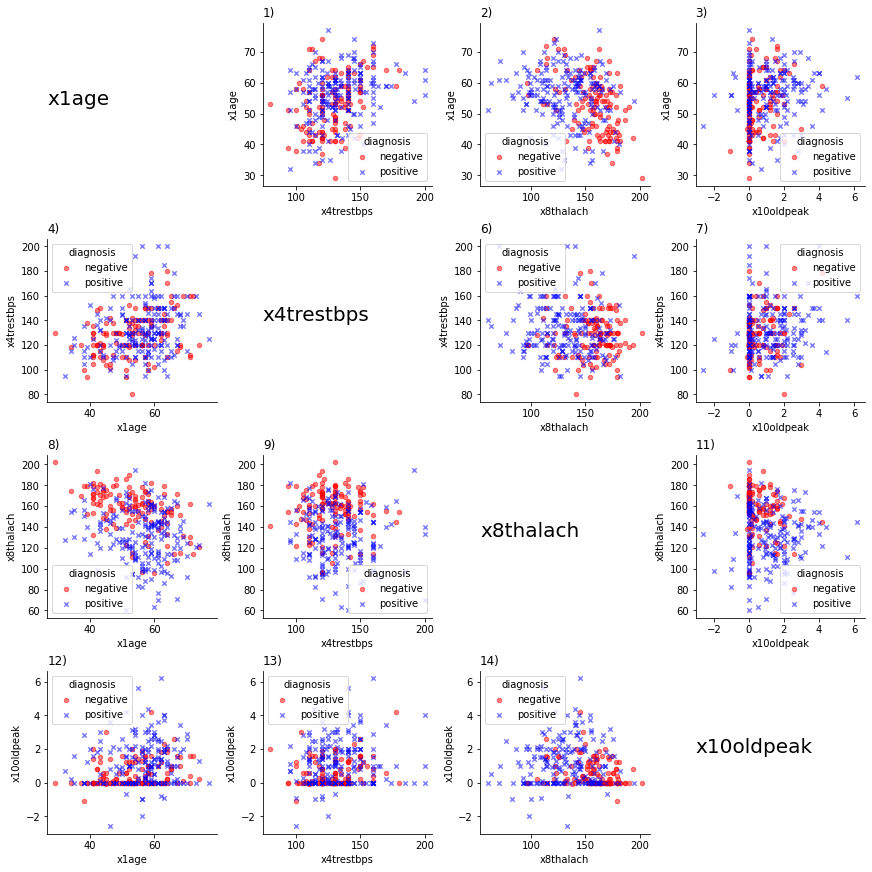

In [ ]:
_ = plot_trellis(
    pd.concat([X_train_test, y_train_test], axis=1),
    legend_title="diagnosis",
    true_label="positive",
    false_label="negative",
)

## Define Loss function

Since the example is about binary classification, we'll use the f1 score for loss

## Train and evaluate the models

In [ ]:
model = LogisticRegressionClassifier(X_train_test, y_train_test)
model.optimize()
print(f"train_loss: {model.get_train_loss()}")
print(f"test_loss: {model.get_test_loss()}")

train_loss: 0.7712418300653594
test_loss: 0.7792207792207793


## Visualize results

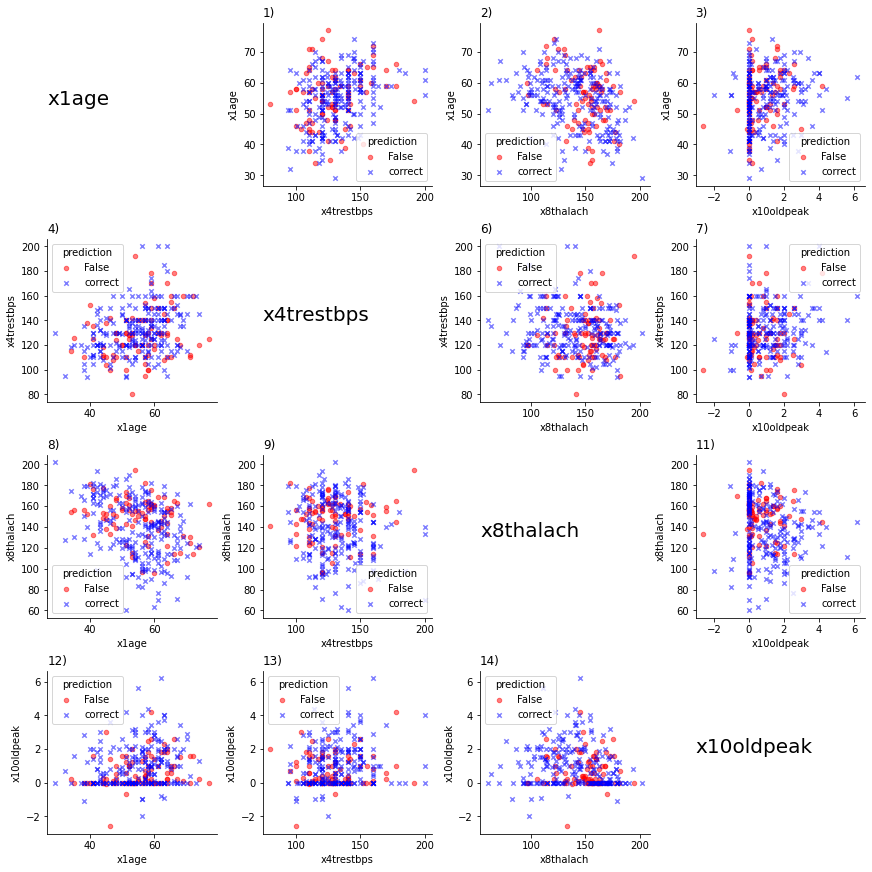

In [ ]:
train_test_df = X_train_test.copy()
train_test_df["prediction_correct"] = (
    model.predict(X_train_test) - y_train_test.values == 0
)
_ = plot_trellis(train_test_df, legend_title="prediction", true_label="correct")

In [ ]:
from scipy.stats import wilcoxon, mannwhitneyu


def test_equality_paired(sample1, sample2, a=0.05):
    reject = lambda p: True if p < a else False
    print("Null hypothesis: samples come from identical distibution")
    stat, p = wilcoxon(sample1, sample2)  # for paired samples
    print(
        f"Willcoxon statistic: {stat}\tp-value: {p}\nnull hypothesis rejected: {reject(p)}"
    )
    print("\n")


def test_equality(sample1, sample2, a=0.05):
    reject = lambda p: True if p < a else False
    print("Null hypothesis: samples come from identical distibution")
    stat, p = mannwhitneyu(sample1, sample2)  # for non-paired samples
    print(
        f"Mann-whitney U statistic: {stat}\tp-value: {p}\nnull hypothesis rejected: {reject(p)}"
    )
    print("\n")

In [ ]:
test_equality(y_train_test, model.predict(X_train_test))
test_equality_paired(y_train_test, model.predict(X_train_test))

Null hypothesis: samples come from identical distibution
Mann-whitney U statistic: 49140.0	p-value: 0.40347409554436137
null hypothesis rejected: False


Null hypothesis: samples come from identical distibution
Willcoxon statistic: 1848.0	p-value: 0.7477301646241347
null hypothesis rejected: False




If the error was just white noise, it the miscellanous predictions should be distributed equal to those that are correct:

In [ ]:
for i in range(train_test_df.shape[1] - 1):
    print(f"Feature: {train_test_df.columns[i]}")
    print("samples: true and false predictions")
    sample1 = train_test_df[train_test_df.prediction_correct == 1].iloc[:, i]
    sample2 = train_test_df[train_test_df.prediction_correct == 0].iloc[:, i]
    test_equality(sample1, sample2)

Feature: x1age
samples: true and false predictions
Null hypothesis: samples come from identical distibution
Mann-whitney U statistic: 9388.0	p-value: 0.2317379388676497
null hypothesis rejected: False


Feature: x4trestbps
samples: true and false predictions
Null hypothesis: samples come from identical distibution
Mann-whitney U statistic: 8782.5	p-value: 0.05770886014528049
null hypothesis rejected: False


Feature: x8thalach
samples: true and false predictions
Null hypothesis: samples come from identical distibution
Mann-whitney U statistic: 7983.5	p-value: 0.0037226331804779966
null hypothesis rejected: True


Feature: x10oldpeak
samples: true and false predictions
Null hypothesis: samples come from identical distibution
Mann-whitney U statistic: 8971.0	p-value: 0.09080807106613303
null hypothesis rejected: False




## Validate best model (if hyperparameters are optimized)

In [ ]:
model.loss(X_val, y_val)

0.7804878048780489

## Visualize validation

In [ ]:
eval_df = pd.DataFrame(
    {
        "train_loss": [model.get_train_loss()],
        "test_loss": [model.get_test_loss()],
        "val_loss": [model.loss(X_val, y_val)],
    }
).T
eval_df

,0
train_loss,0.771242
test_loss,0.779221
val_loss,0.780488


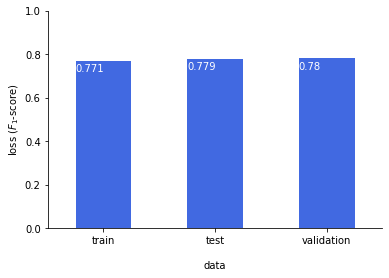

In [ ]:
fig, ax = plt.subplots(1)

# plot settings
barcolor = "royalblue"
barwidth = 0.5

eval_df.plot(ax=ax, kind="bar", width=barwidth, color=barcolor)
ax.set_ylim(ymax=1)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.get_legend().remove()

# offsets and colours for annotation:
text_offset = 0.05
upper_lower = lambda x: x - text_offset if x > 0.5 else x + text_offset
black_white = lambda x: "white" if x > 0.5 else barcolor
# annotate:
for i in range(eval_df.shape[0]):
    val = round(eval_df.iloc[i].values[0], 3)
    ax.annotate(
        text=f"{val}",
        xy=(i - barwidth / 2, upper_lower(val)),
        color=black_white(val),
    )
# rename axis
ax.set_ylabel("loss ($F_1$-score)")
ax.set_xlabel("\ndata")
ax.set_xticklabels(["train", "test", "validation"], rotation=0)
plt.show()

## Conclusions

Explain the model behaviour results to your best understanding

compare to benchmark results

## Save results, including fitted models and hyperparameters for production use

Save (example: pickle, in practice edit model class to have a save to json/yml - load from json/yml option)

At this point model is ready to be pushed to production, for example as an `azure ml model`

You can also include acception tests as a condition for shipping to production, for example that the loss must have at least / minimum a certain value. This makes model update automation easier.

At this point, you can also publish the modules created as a python package.

In [ ]:
import pickle

filename = "results/LogisticRegressionClassifier.pkl"
with open(filename, "wb") as f:
    pickle.dump(model, f)

You can now load the pickled trained model in another environment (installed with dependencies defined in requirements.txt)
```
with open(filename, "rb") as f:
    model = pickle.load(f)
```

In [ ]:
# test
with open(filename, "rb") as f:
    assert pickle.load(f).get_train_loss() == model.get_train_loss()

0.7712418300653594